In [1]:
import numpy as np
import mne # docu: https://mne.tools/stable/overview/index.html
import pandas as pd
import matplotlib.pyplot as plt
import glob
import mne_connectivity as mne_connect
from autoreject import get_rejection_threshold
from mne.preprocessing import EOGRegression

# https://neuraldatascience.io/7-eeg/mne_data.html
%matplotlib widget

### Načtení dat, anotace

In [2]:
patient_number = 5
path_to_folder = f"../data_ukazka/sub-S0{patient_number}/"
file_name = f"sub-S0{patient_number}"

In [3]:
raw = mne.io.read_raw_eximia(path_to_folder+file_name+".nxe", preload=True, verbose=None)
raw_data = raw.get_data()
raw.set_montage('standard_1005')
raw.__dict__

Loading sub-S05.nxe
Reading 0 ... 1163655  =      0.000 ...   802.521 secs...


{'_last_samps': array([1163655]),
 '_first_samps': array([0]),
 'info': <Info | 8 non-empty values
  bads: []
  ch_names: GateIn, Trig1, Trig2, EOG, Fp1, Fpz, Fp2, AF1, AFz, AF2, F7, F3, ...
  chs: 3 Stimulus, 1 EOG, 60 EEG
  custom_ref_applied: False
  dig: 63 items (3 Cardinal, 60 EEG)
  highpass: 0.0 Hz
  lowpass: 725.0 Hz
  meas_date: unspecified
  nchan: 64
  projs: []
  sfreq: 1450.0 Hz
 >,
 'buffer_size_sec': 1.0,
 '_cals': array([0.0015259 , 0.0015259 , 0.0015259 , 0.38147555, 0.07629511,
        0.07629511, 0.07629511, 0.07629511, 0.07629511, 0.07629511,
        0.07629511, 0.07629511, 0.07629511, 0.07629511, 0.07629511,
        0.07629511, 0.07629511, 0.07629511, 0.07629511, 0.07629511,
        0.07629511, 0.07629511, 0.07629511, 0.07629511, 0.07629511,
        0.07629511, 0.07629511, 0.07629511, 0.07629511, 0.07629511,
        0.07629511, 0.07629511, 0.07629511, 0.07629511, 0.07629511,
        0.07629511, 0.07629511, 0.07629511, 0.07629511, 0.07629511,
        0.07629511, 0.

In [4]:
events = mne.find_events(raw, stim_channel=["GateIn","Trig1","Trig2"],min_duration = 2 / raw.info['sfreq'])

331 events found
Event IDs: [4]


In [5]:
mapping = {
    4: "trigger",
}
annot_from_events = mne.annotations_from_events(
    events=events,
    event_desc=mapping,
    sfreq=raw.info["sfreq"],
    orig_time=raw.info["meas_date"],
)
raw.set_annotations(annot_from_events)
raw.annotations

<Annotations | 331 segments: trigger (331)>

### Vyříznutí a interpolace stimulací

-  <https://nigelrogasch.gitbook.io/tesa-user-manual/remove_interpolate>
- debata MNE na podobné téma <https://mne.discourse.group/t/replacing-data-in-the-specific-time-range-with-nan/5244/10>

Using matplotlib as 2D backend.


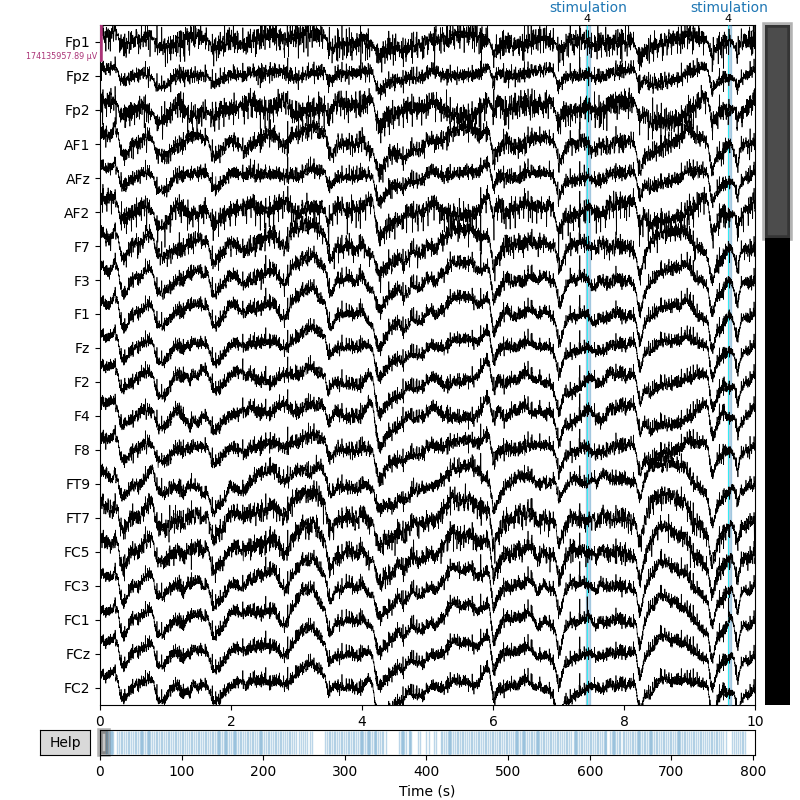

In [6]:
before_stimulation = 0.01
after_stimulation = 0.05
duration = before_stimulation + after_stimulation

onsets = events[:, 0] / raw.info["sfreq"] - before_stimulation
durations = [duration] * len(events)
descriptions = ["stimulation"] * len(events)
stimulation_annot = mne.Annotations(
    onsets, durations, descriptions, orig_time=raw.info["meas_date"]
)
raw.set_annotations(stimulation_annot)
raw.plot(events=events,scalings='auto');

Creating RawArray with float64 data, n_channels=64, n_times=1163656
    Range : 0 ... 1163655 =      0.000 ...   802.521 secs
Ready.
Overwriting existing file.
Writing /home/katterrina/fi_muni/0_diplomka/notebooks/../data_ukazka/sub-S05/sub-S05-interpolated.fif


/tmp/ipykernel_21391/932381035.py:20: RuntimeWarning: This filename (/home/katterrina/fi_muni/0_diplomka/notebooks/../data_ukazka/sub-S05/sub-S05-interpolated.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_interpolated.save(path_to_folder+file_name+"-interpolated.fif", overwrite=True)


Closing /home/katterrina/fi_muni/0_diplomka/notebooks/../data_ukazka/sub-S05/sub-S05-interpolated.fif
[done]


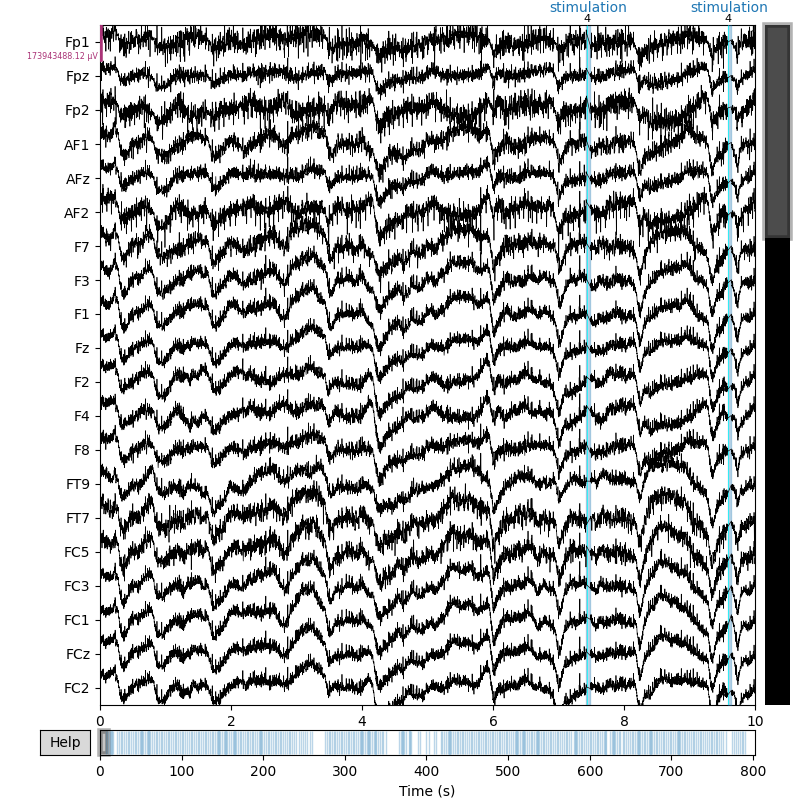

In [7]:
data = raw.get_data()

# %%
event_onset_samples = events[:, 0] - raw.first_samp  # don't forget first_samp!
for event_onset_sample in event_onset_samples:
    samp_start = event_onset_sample - int(raw.info["sfreq"] * before_stimulation)
    samp_end = event_onset_sample + int(raw.info["sfreq"] * after_stimulation)
    for d in data:
        d[samp_start:samp_end] = np.interp(list(range(samp_start,samp_end)),[samp_start-1,samp_end],[d[samp_start-1],d[samp_end]])

raw_interpolated = mne.io.RawArray(
    data=data,
    info=raw.info,
    first_samp=raw.first_samp,  # don't forget first_samp!
)
raw_interpolated.set_annotations(stimulation_annot)

del raw

raw_interpolated.save(path_to_folder+file_name+"-interpolated.fif", overwrite=True)

raw_interpolated.plot(events=events,scalings='auto');

### Band-pass filtering

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)


- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 Hz)
- Filter length: 4785 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.9s


Effective window size : 1.412 (s)


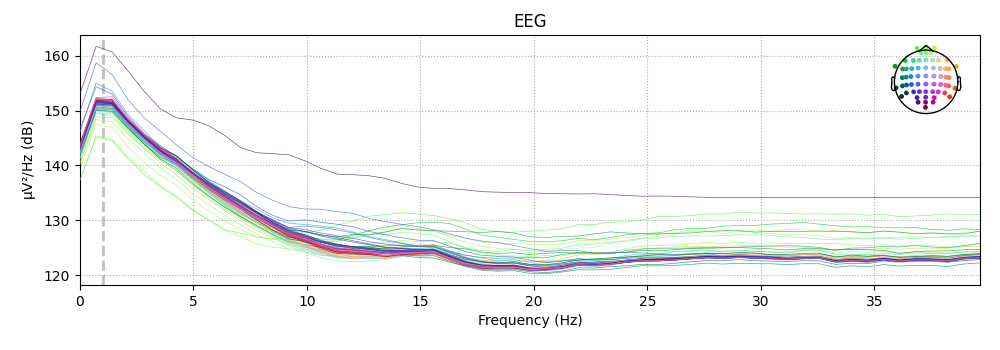

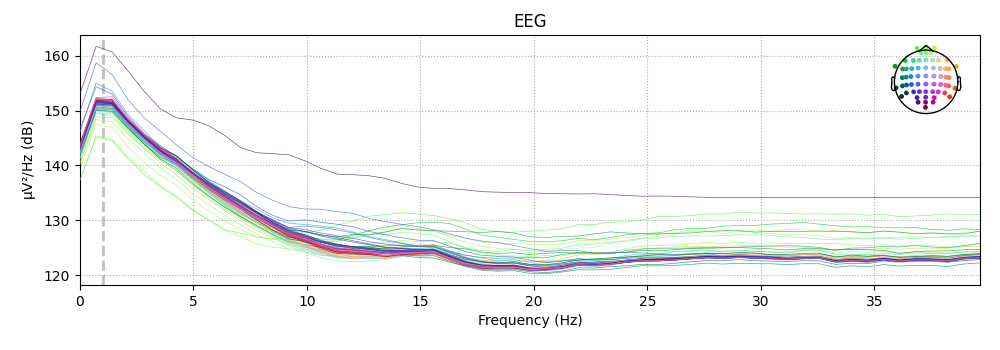

In [8]:
# Filter settings (podle Honzova notebooku)
low_cut = 1
hi_cut  = 80

raw_filtered = raw_interpolated.filter(low_cut, hi_cut,picks=['eeg','eog'])
raw_filtered.compute_psd(fmax=40).plot();

In [9]:
raw_filtered.save(path_to_folder+file_name+"-interpolated-filtered.fif", overwrite=True)

Writing /home/katterrina/fi_muni/0_diplomka/notebooks/../data_ukazka/sub-S05/sub-S05-interpolated-filtered.fif


/tmp/ipykernel_21391/3498079990.py:1: RuntimeWarning: This filename (/home/katterrina/fi_muni/0_diplomka/notebooks/../data_ukazka/sub-S05/sub-S05-interpolated-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_filtered.save(path_to_folder+file_name+"-interpolated-filtered.fif", overwrite=True)


Closing /home/katterrina/fi_muni/0_diplomka/notebooks/../data_ukazka/sub-S05/sub-S05-interpolated-filtered.fif
[done]


### Převedení na epochy

In [10]:
# Epoching settings
tmin =  -.1  # start of each epoch (in sec)
tmax =  0.5  # end of each epoch (in sec)
baseline = (None, 0)

raw_filtered.set_eeg_reference("average")
# Create epochs
events, event_dict = mne.events_from_annotations(raw_filtered)
epochs = mne.Epochs(raw_filtered,
                    events, event_dict,
                    tmin, tmax,
                    baseline=baseline, 
                    preload=True) 

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['stimulation']
Not setting metadata
331 matching events found
Setting baseline interval to [-0.1, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 331 events and 871 original time points ...
0 bad epochs dropped


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


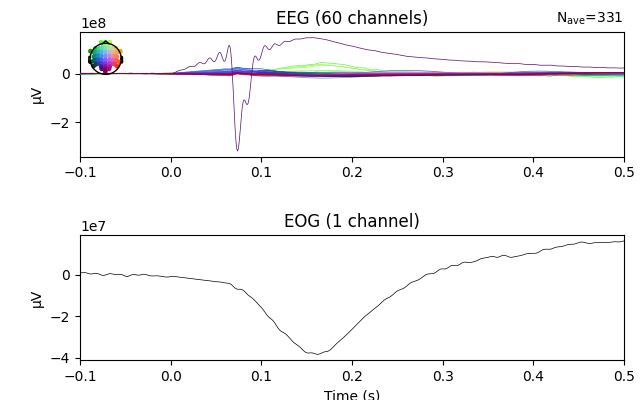

In [11]:
epochs.average("all").plot(); # before removing ICs, so that we can compare with post-ICA below to see the effect of artifact removal

### Odstranění vadných kanálů

Not setting metadata
331 matching events found
Setting baseline interval to [-0.1, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 331 events and 871 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


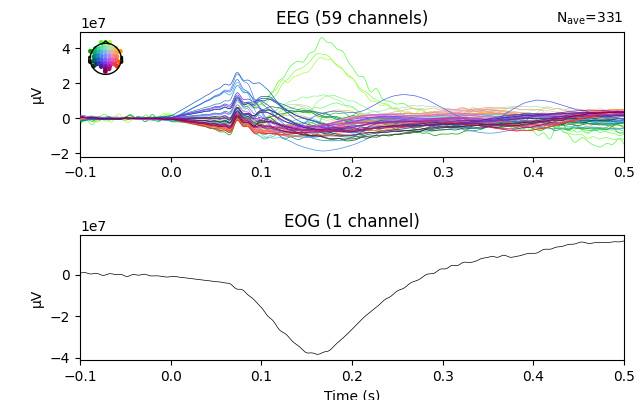

In [12]:
# tady asi je na řadě mark bad channels, pokud pro konkrétní data jsou 
# https://mne.tools/stable/auto_tutorials/preprocessing/15_handling_bad_channels.html

# S01 možná
# raw_filtered.info["bads"].append("Oz")

# S05
raw_filtered.info["bads"].append("O1")

epochs = mne.Epochs(raw_filtered,
                    events, event_dict,
                    tmin, tmax,
                    baseline=baseline, 
                    preload=True) 

epochs.average("all").plot();

### EOG regrese

No projector specified for this dataset. Please consider the method self.add_proj.


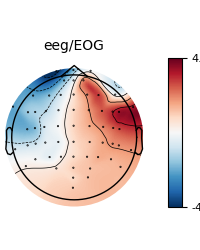

In [13]:
model_plain = EOGRegression(picks="eeg", picks_artifact="eog").fit(epochs)
model_plain.plot(vlim=(None, 0.4));  # regression coefficients as topomap

No projector specified for this dataset. Please consider the method self.add_proj.


Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


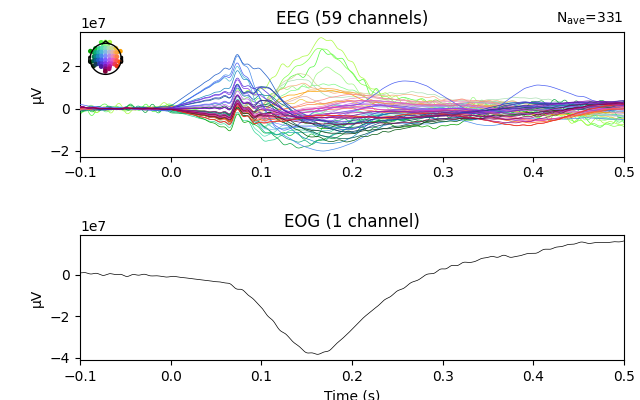

In [14]:
epochs_clean_plain = model_plain.apply(epochs)
# After regression, we should redo the baseline correction
epochs_clean_plain.apply_baseline()
# Show the evoked potential computed on the corrected data
epochs_clean_plain.average("all").plot();

In [15]:
epochs_clean_plain.save(path_to_folder+file_name+"-epochs.fif",overwrite=True)

/tmp/ipykernel_21391/1693177536.py:1: RuntimeWarning: This filename (../data_ukazka/sub-S05/sub-S05-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_clean_plain.save(path_to_folder+file_name+"-epochs.fif",overwrite=True)
